In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import datetime
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from fbprophet import Prophet

from fastdtw import fastdtw  # https://github.com/slaypni/fastdtw

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [2]:
np.random.seed(42)
plt.rcParams['figure.figsize'] = 20, 15

### Загрузка данных

In [3]:
TypeMap = {'Indicator': str}
df = pd.read_csv('./data/sensor_data.csv', dtype=TypeMap)
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%Y%m%d%H%M%S')
df.head()

,Controller ID,Sensor 1 value,Sensor 1 ID,Sensor 2 value,Sensor 2 ID,Sensor 3 value,Sensor 3 ID,Sensor 4 value,Sensor 4 ID,Sensor 5 value,Sensor 5 ID,Timestamp,Indicator,Number of queries
0,1,1,1,16.4,2,1,3,16.4,4,16.4,5,2017-11-24 14:50:59,00000,NaN
1,1,1,1,16.4,2,1,3,16.4,4,16.4,5,2017-11-24 14:52:47,00000,1.0
2,1,1,1,16.4,2,1,3,16.4,4,16.4,5,2017-11-24 14:52:47,00000,1.0
3,1,1,1,16.4,2,1,3,16.4,4,16.4,5,2017-11-24 15:03:07,00000,1.0
4,1,1,1,16.4,2,1,3,16.4,4,16.4,5,2017-11-24 15:10:03,00000,1.0


In [4]:
df.drop(['Controller ID', 'Sensor 1 ID', 'Sensor 2 ID', 'Sensor 3 ID', 'Sensor 4 ID', 'Sensor 5 ID', 
                       'Indicator', 'Number of queries'], axis=1, inplace=True)

In [5]:
len(df)

66599

In [6]:
df.head()

,Sensor 1 value,Sensor 2 value,Sensor 3 value,Sensor 4 value,Sensor 5 value,Timestamp
0,1,16.4,1,16.4,16.4,2017-11-24 14:50:59
1,1,16.4,1,16.4,16.4,2017-11-24 14:52:47
2,1,16.4,1,16.4,16.4,2017-11-24 14:52:47
3,1,16.4,1,16.4,16.4,2017-11-24 15:03:07
4,1,16.4,1,16.4,16.4,2017-11-24 15:10:03


In [7]:
def roundTime(dt=None, dateDelta=datetime.timedelta(minutes=1)):
    roundTo = dateDelta.total_seconds()
    if dt == None: 
        dt = datetime.datetime.now()
    seconds = (dt - dt.min).seconds
    rounding = (seconds+roundTo/2) // roundTo * roundTo
    return dt + datetime.timedelta(0,rounding-seconds,-dt.microsecond)

In [8]:
df['Timestamp'] = df['Timestamp'].apply(roundTime)

In [9]:
df = df.drop_duplicates(['Timestamp'])

In [10]:
df

,Sensor 1 value,Sensor 2 value,Sensor 3 value,Sensor 4 value,Sensor 5 value,Timestamp
0,1,16.4,1,16.4,16.4,2017-11-24 14:50:44
1,1,16.4,1,16.4,16.4,2017-11-24 14:52:44
3,1,16.4,1,16.4,16.4,2017-11-24 15:02:44
4,1,16.4,1,16.4,16.4,2017-11-24 15:09:44
6,1,16.3,1,16.3,16.3,2017-11-24 15:17:44
7,1,16.3,1,16.3,16.3,2017-11-24 15:18:44
8,1,16.3,1,16.3,16.3,2017-11-24 15:23:44
11,1,15.8,1,15.8,15.8,2017-11-27 10:13:44
12,1,15.8,1,15.8,15.8,2017-11-27 10:14:44
13,1,15.8,1,15.8,15.8,2017-11-27 10:15:44


In [11]:
 delta = int((df['Timestamp'][66598] - df['Timestamp'][0]).total_seconds() // 60)

In [12]:
prophetdf = pd.DataFrame()
prophetdf['ds'] = df['Timestamp'][:5]
prophetdf['y'] = df['Sensor 1 value'][:5]
m = Prophet()
m.fit(prophetdf)
full_df = m.make_future_dataframe(periods=delta-27, freq='T')
full_df.tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.


,ds
89266,2018-01-25 14:59:44
89267,2018-01-25 15:00:44
89268,2018-01-25 15:01:44
89269,2018-01-25 15:02:44
89270,2018-01-25 15:03:44


In [13]:
df.index = df['Timestamp']

In [14]:
full_df = full_df.join(df, on='ds', how='left')

In [15]:
full_df.drop(['Timestamp'], axis=1, inplace=True)

In [16]:
full_df

,ds,Sensor 1 value,Sensor 2 value,Sensor 3 value,Sensor 4 value,Sensor 5 value
0,2017-11-24 14:50:44,1.0,16.4,1.0,16.4,16.4
1,2017-11-24 14:52:44,1.0,16.4,1.0,16.4,16.4
2,2017-11-24 15:02:44,1.0,16.4,1.0,16.4,16.4
3,2017-11-24 15:09:44,1.0,16.4,1.0,16.4,16.4
4,2017-11-24 15:17:44,1.0,16.3,1.0,16.3,16.3
5,2017-11-24 15:18:44,1.0,16.3,1.0,16.3,16.3
6,2017-11-24 15:19:44,NaN,NaN,NaN,NaN,NaN
7,2017-11-24 15:20:44,NaN,NaN,NaN,NaN,NaN
8,2017-11-24 15:21:44,NaN,NaN,NaN,NaN,NaN
9,2017-11-24 15:22:44,NaN,NaN,NaN,NaN,NaN


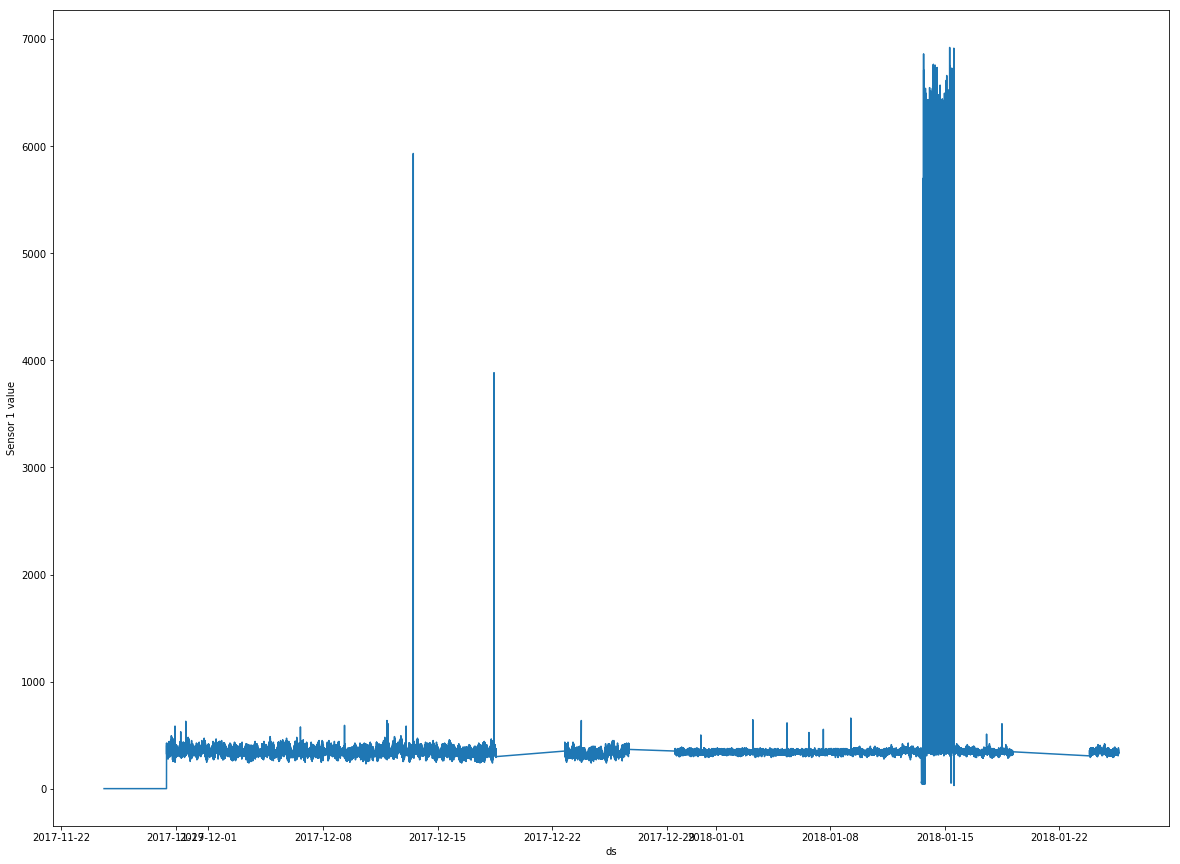

In [17]:
sns.lineplot(data=full_df, x='ds', y='Sensor 1 value')

In [18]:
full_df = full_df[7500:]

In [19]:
full_df.head()

,ds,Sensor 1 value,Sensor 2 value,Sensor 3 value,Sensor 4 value,Sensor 5 value
7500,2017-11-29 20:13:44,292.0,17.2,5677.0,9.5,16.7
7501,2017-11-29 20:14:44,330.0,17.2,5392.0,8.4,16.7
7502,2017-11-29 20:15:44,307.0,16.2,285.0,10.0,16.7
7503,2017-11-29 20:16:44,322.0,16.2,262.0,13.6,16.7
7504,2017-11-29 20:17:44,412.0,17.3,307.0,16.1,16.7


### Фильрация выбросов

In [22]:
full_df.describe()

,Sensor 1 value,Sensor 2 value,Sensor 3 value,Sensor 4 value,Sensor 5 value
count,63191.000000,63191.000000,63191.000000,63191.000000,63191.000000
mean,463.873004,16.679382,3943.344622,9.843375,16.379513
std,779.435147,0.857643,2354.638842,4.307513,0.637389
min,30.000000,9.800000,37.000000,-11.600000,13.300000
25%,330.000000,16.400000,300.000000,7.900000,15.900000
50%,345.000000,16.600000,5145.000000,9.000000,16.400000
75%,360.000000,17.300000,5610.000000,12.800000,16.600000
max,6922.000000,20.900000,7672.000000,17.600000,24.000000


In [23]:
full_df

,ds,Sensor 1 value,Sensor 2 value,Sensor 3 value,Sensor 4 value,Sensor 5 value
7500,2017-11-29 20:13:44,292.0,17.2,5677.0,9.5,16.7
7501,2017-11-29 20:14:44,330.0,17.2,5392.0,8.4,16.7
7502,2017-11-29 20:15:44,307.0,16.2,285.0,10.0,16.7
7503,2017-11-29 20:16:44,322.0,16.2,262.0,13.6,16.7
7504,2017-11-29 20:17:44,412.0,17.3,307.0,16.1,16.7
7505,2017-11-29 20:18:44,315.0,17.3,5280.0,13.6,16.7
7506,2017-11-29 20:19:44,322.0,17.3,5715.0,10.9,16.7
7507,2017-11-29 20:20:44,NaN,NaN,NaN,NaN,NaN
7508,2017-11-29 20:21:44,337.0,17.3,5850.0,8.7,16.7
7509,2017-11-29 20:22:44,307.0,16.3,5722.0,8.7,16.7


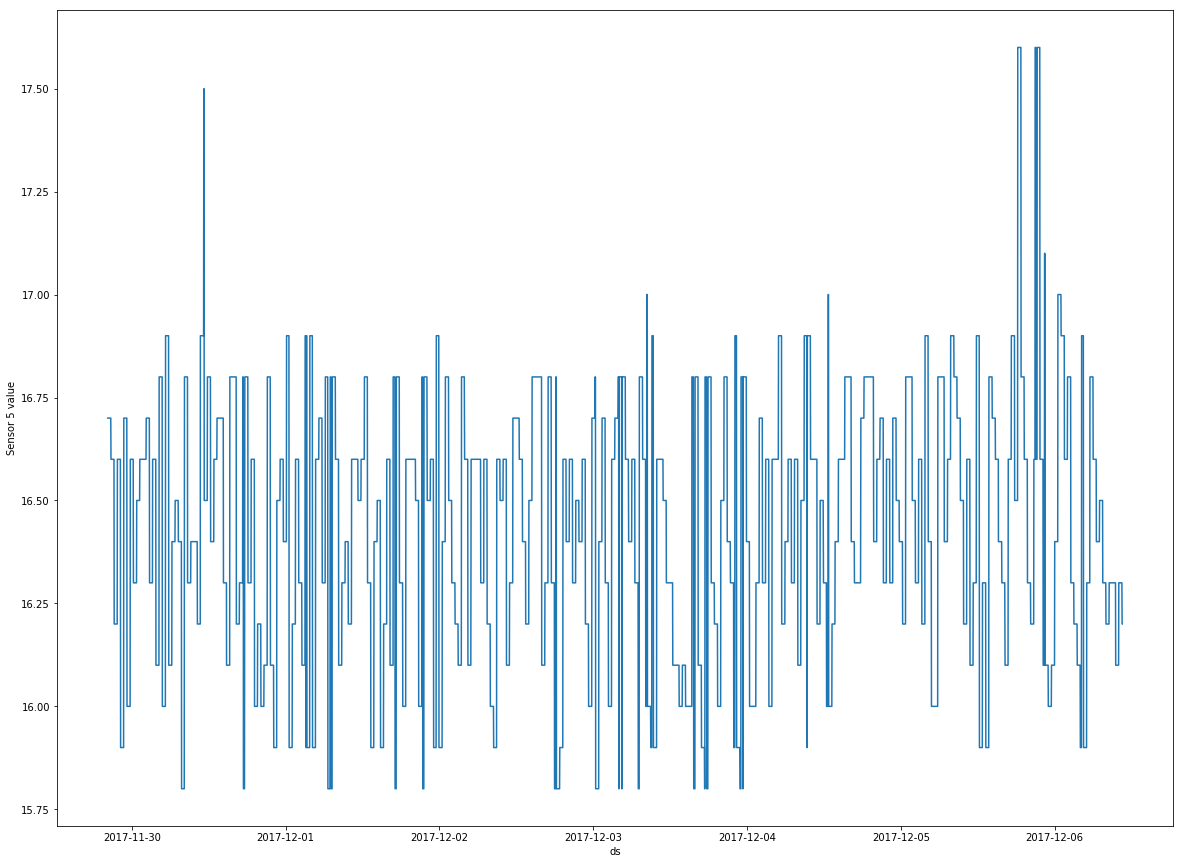

In [24]:
sns.lineplot(data=full_df[:9500], x='ds', y='Sensor 5 value')

In [25]:
norm_df = full_df[:9500]

In [28]:
prophetdf = pd.DataFrame()
prophetdf['ds'] = norm_df['ds']
prophetdf['y'] = norm_df['Sensor 5 value']
prophetdf.head()

,ds,y
7500,2017-11-29 20:13:44,16.7
7501,2017-11-29 20:14:44,16.7
7502,2017-11-29 20:15:44,16.7
7503,2017-11-29 20:16:44,16.7
7504,2017-11-29 20:17:44,16.7


In [29]:
m = Prophet()
m.fit(prophetdf)
future = m.make_future_dataframe(periods=0, freq='m')
future.tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
c:\anaconda\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


,ds
9495,2017-12-06 10:28:44
9496,2017-12-06 10:29:44
9497,2017-12-06 10:30:44
9498,2017-12-06 10:31:44
9499,2017-12-06 10:32:44


In [30]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
9495,2017-12-06 10:28:44,16.366546,15.966005,16.788408
9496,2017-12-06 10:29:44,16.366563,15.975261,16.747653
9497,2017-12-06 10:30:44,16.366579,15.984842,16.768044
9498,2017-12-06 10:31:44,16.366593,15.981259,16.762769
9499,2017-12-06 10:32:44,16.366607,15.978902,16.750782


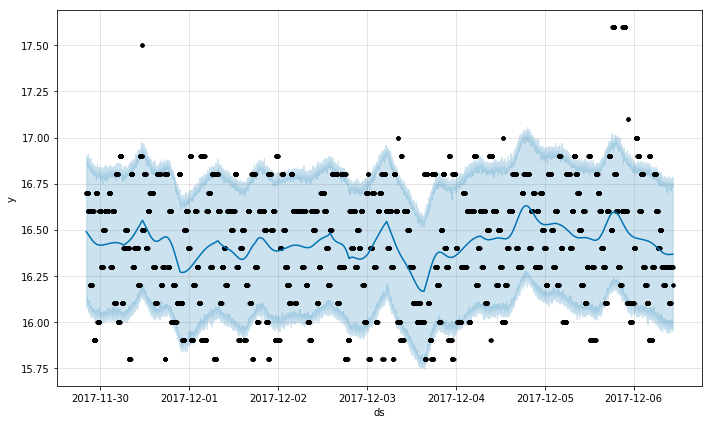

In [31]:
fig1 = m.plot(forecast)

In [32]:
norm_df['dif'] = abs(forecast['yhat'].values - norm_df['Sensor 5 value'].values)

c:\anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


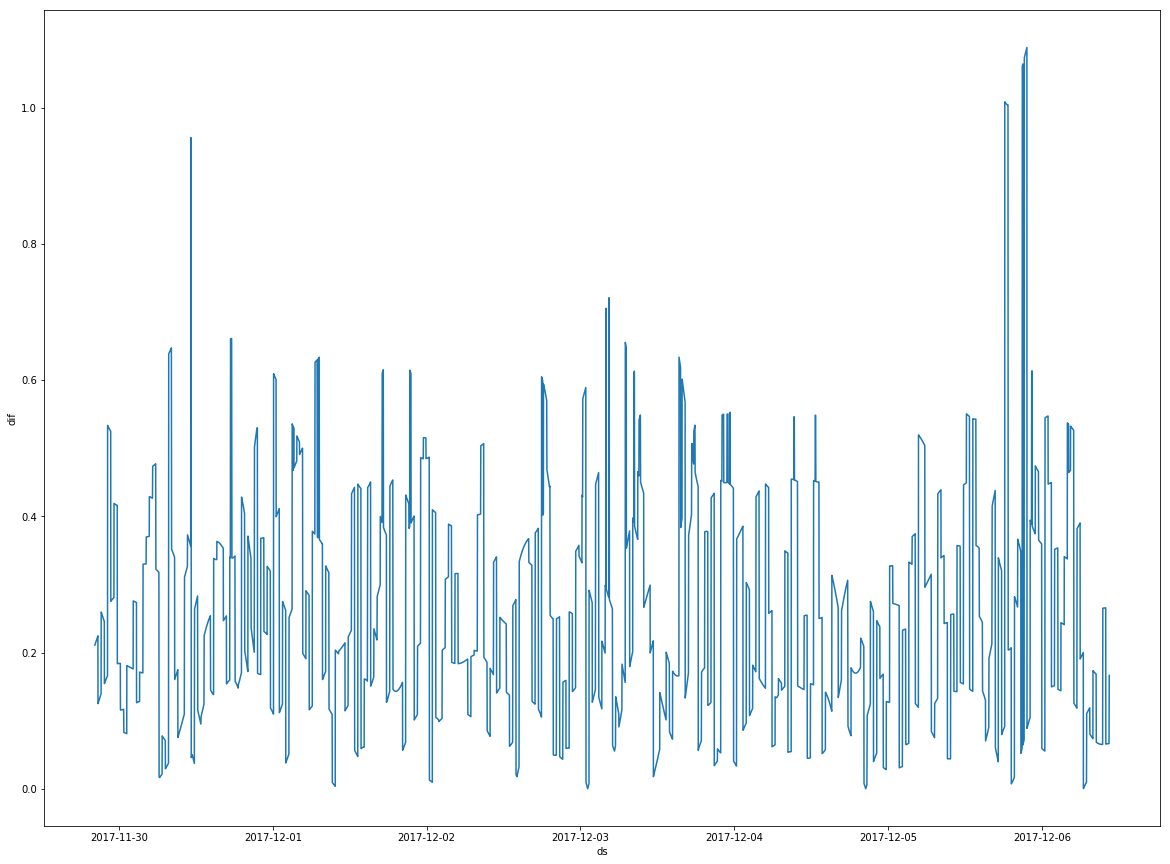

In [33]:
sns.lineplot(data=norm_df, x='ds', y='dif')

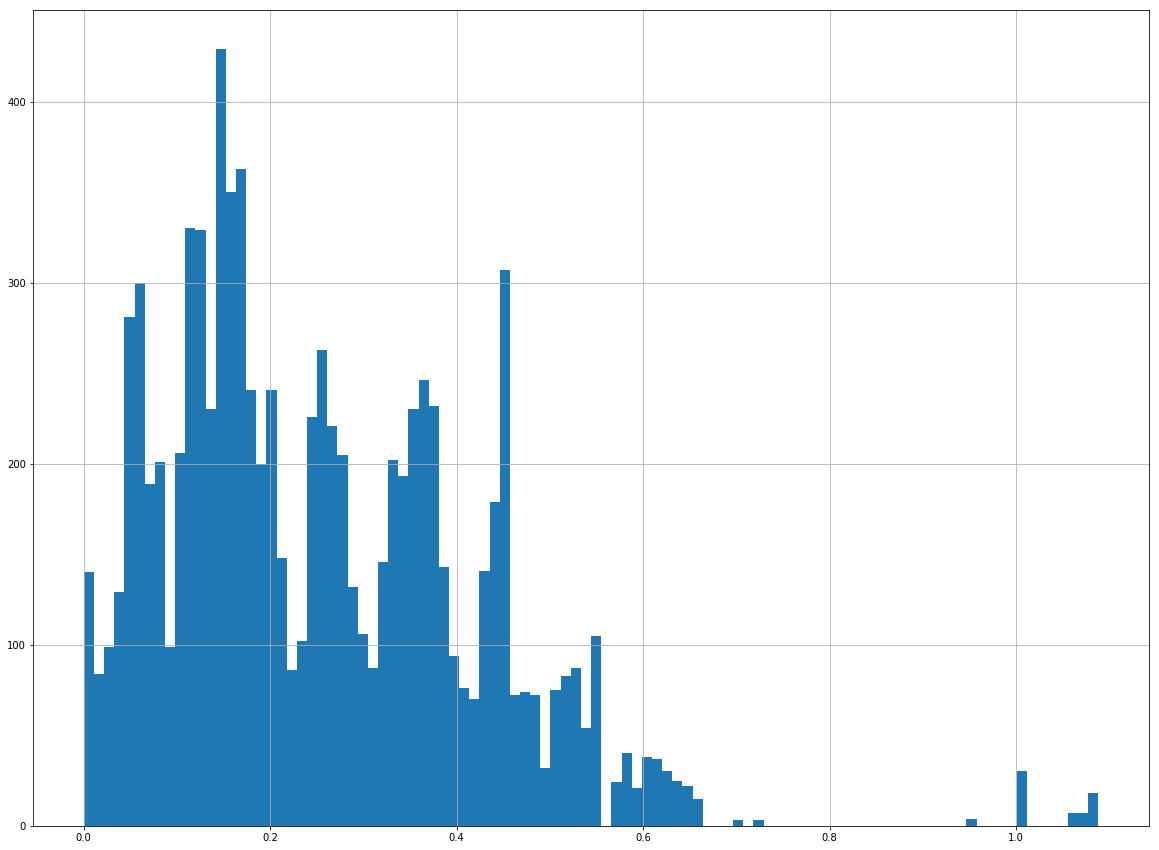

In [34]:
norm_df['dif'].hist(bins=100)

In [35]:
prophetdf = pd.DataFrame()
prophetdf['ds'] = full_df['ds']
prophetdf['y'] = full_df['Sensor 5 value']
prophetdf.head()

,ds,y
7500,2017-11-29 20:13:44,16.7
7501,2017-11-29 20:14:44,16.7
7502,2017-11-29 20:15:44,16.7
7503,2017-11-29 20:16:44,16.7
7504,2017-11-29 20:17:44,16.7


In [36]:
forecast = m.predict(prophetdf)

In [37]:
full_df['dif'] = abs(forecast['yhat'].values - full_df['Sensor 5 value'].values)

c:\anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


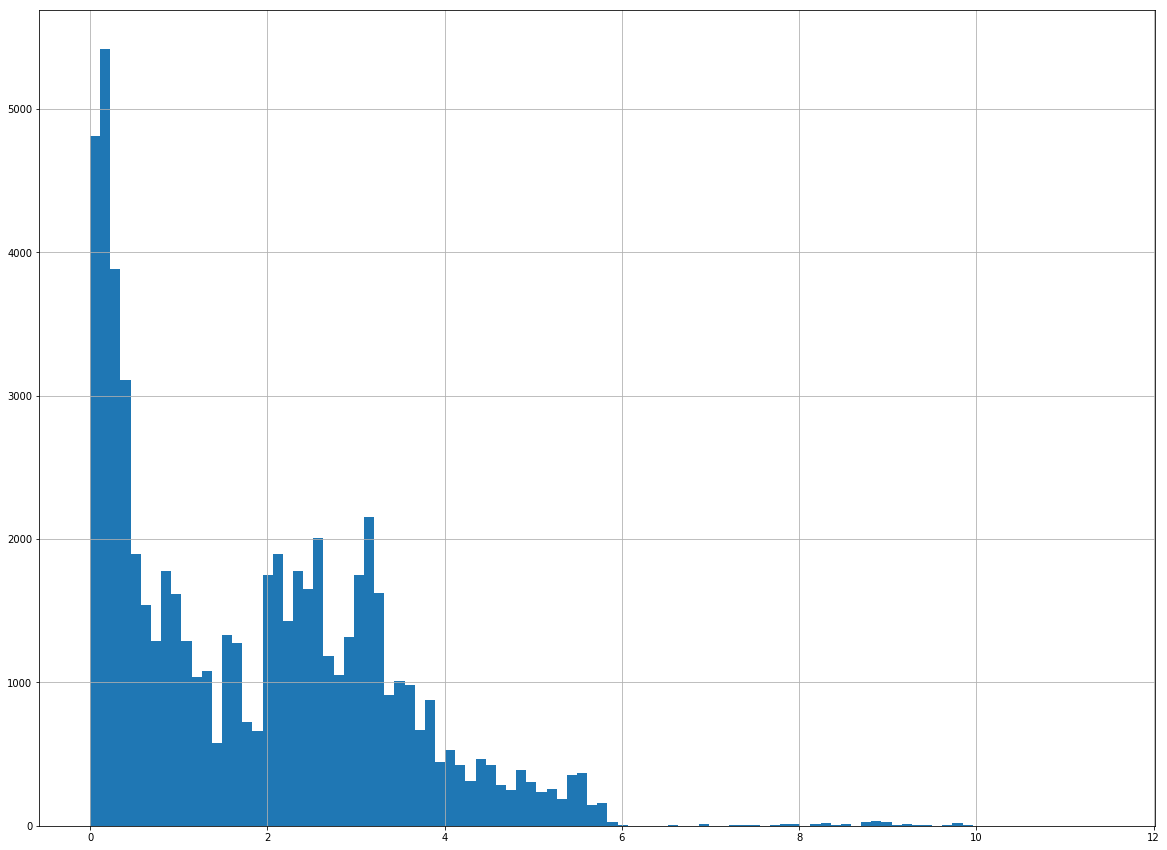

In [38]:
full_df['dif'].hist(bins=100)

In [39]:
full_df['dif'].describe()

count    63191.000000
mean         1.855077
std          1.528169
min          0.000025
25%          0.397851
50%          1.683017
75%          2.978403
max         11.445512
Name: dif, dtype: float64

In [40]:
full_df['dif'].quantile(0.9)

3.8560719212540704

In [41]:
full_df['dif'].quantile(0.95)

4.633274336033184

In [42]:
full_df['dif'].quantile(0.99)

5.598709978925105

In [43]:
threshold = full_df['dif'].std() * 3
threshold

4.584506412990643

In [44]:
a = full_df.loc[full_df['dif']>threshold]

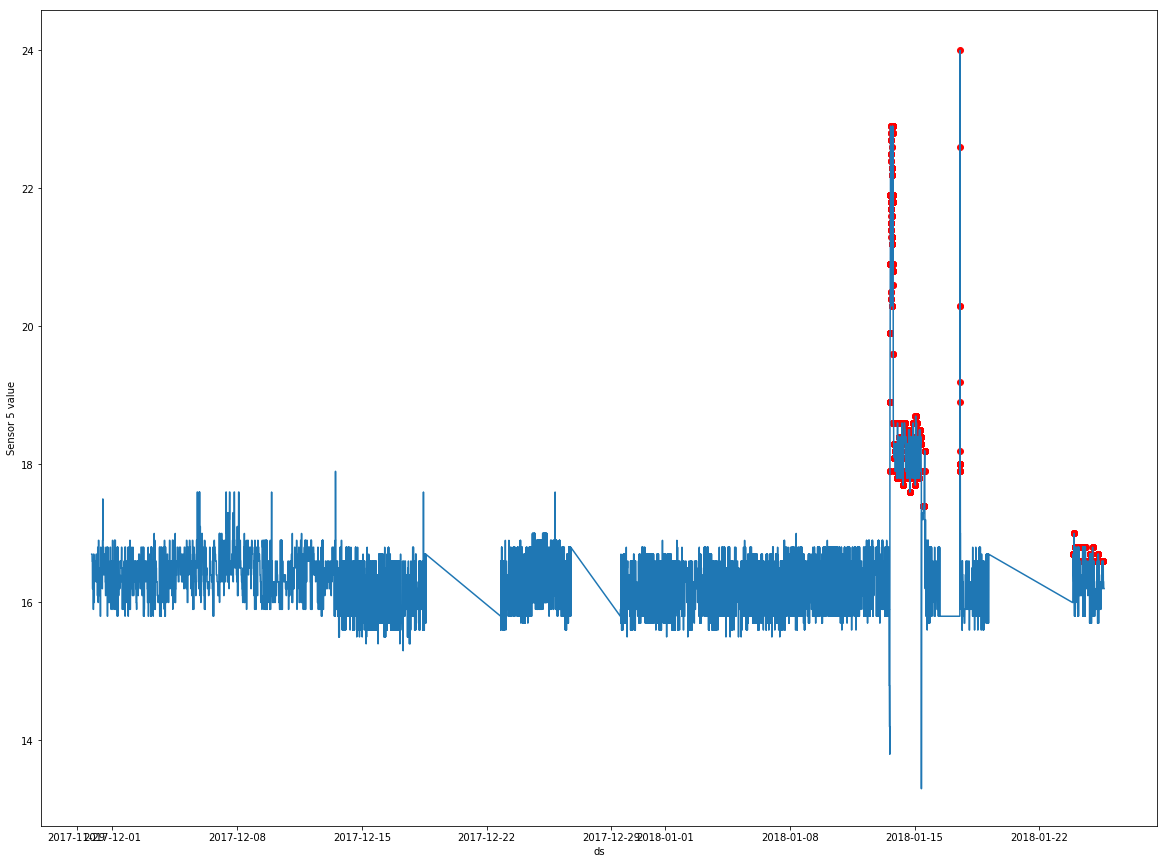

In [45]:
fig, ax = plt.subplots(figsize=(20, 15))
sns.lineplot(data=full_df, x='ds', y='Sensor 5 value')
ax.scatter(a['ds'], a['Sensor 5 value'], color='red')

In [47]:
num_cols = ['Sensor 1 value', 'Sensor 2 value', 'Sensor 3 value', 'Sensor 4 value', 'Sensor 5 value']

In [49]:
for col in num_cols:
    prophetdf = pd.DataFrame()
    prophetdf['ds'] = norm_df['ds']
    prophetdf['y'] = norm_df[col]
    m = Prophet()
    m.fit(prophetdf)
    
    prophetdf = pd.DataFrame()
    prophetdf['ds'] = full_df['ds']
    prophetdf['y'] = full_df[col]
    forecast = m.predict(prophetdf)
    
    prophetdf['dif'] = abs(forecast['yhat'].values - full_df[col].values)
    threshold = prophetdf['dif'].std() * 3
    prophetdf['anomaly'] = prophetdf['dif'] > threshold
    full_df[col] = prophetdf.apply(lambda x: x['y'] if not x['anomaly'] else np.nan, axis=1)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
c:\anaconda\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabl

In [50]:
full_df.head()

,ds,Sensor 1 value,Sensor 2 value,Sensor 3 value,Sensor 4 value,Sensor 5 value,dif
7500,2017-11-29 20:13:44,292.0,17.2,5677.0,9.5,16.7,0.211057
7501,2017-11-29 20:14:44,330.0,17.2,5392.0,8.4,16.7,0.211489
7502,2017-11-29 20:15:44,307.0,16.2,285.0,10.0,16.7,0.211924
7503,2017-11-29 20:16:44,322.0,16.2,262.0,13.6,16.7,0.212363
7504,2017-11-29 20:17:44,412.0,17.3,307.0,16.1,16.7,0.212805


In [51]:
full_df.describe()

,Sensor 1 value,Sensor 2 value,Sensor 3 value,Sensor 4 value,Sensor 5 value,dif
count,61708.000000,61592.000000,60819.000000,60489.000000,59955.000000,63191.000000
mean,343.842403,16.785328,4086.934313,10.502344,16.283993,1.855077
std,30.770898,0.498126,2282.801088,2.997402,0.412670,1.528169
min,30.000000,14.500000,52.000000,0.800000,13.300000,0.000025
25%,330.000000,16.400000,330.000000,8.000000,15.900000,0.397851
50%,345.000000,16.600000,5182.000000,9.300000,16.300000,1.683017
75%,360.000000,17.300000,5625.000000,12.900000,16.600000,2.978403
max,660.000000,18.600000,7672.000000,17.600000,17.900000,11.445512


In [52]:
full_df.to_csv('./data/full_df.csv', index=False)

### Заполнение пропусков

In [3]:
full_df = pd.read_csv('./data/full_df.csv', parse_dates=[1])

In [4]:
len(full_df)

81771

In [5]:
full_df.isnull().sum()

Unnamed: 0            0
ds                    0
Sensor 1 value    20063
Sensor 2 value    20179
Sensor 3 value    20952
Sensor 4 value    21282
Sensor 5 value    21816
dif               18580
dtype: int64

In [7]:
full_df.drop(['dif'], axis=1, inplace=True)

### Интерполяция для единичных пропусков

In [8]:
full_df.head()

,ds,Sensor 1 value,Sensor 2 value,Sensor 3 value,Sensor 4 value,Sensor 5 value
0,2017-11-29 20:13:44,292.0,17.2,5677.0,9.5,16.7
1,2017-11-29 20:14:44,330.0,17.2,5392.0,8.4,16.7
2,2017-11-29 20:15:44,307.0,16.2,285.0,10.0,16.7
3,2017-11-29 20:16:44,322.0,16.2,262.0,13.6,16.7
4,2017-11-29 20:17:44,412.0,17.3,307.0,16.1,16.7


In [9]:
full_df.interpolate(method='linear', limit_direction='both', limit_area='inside', axis=0, limit=3, inplace=True)

In [10]:
full_df.isnull().sum()

ds                    0
Sensor 1 value    16796
Sensor 2 value    16961
Sensor 3 value    16787
Sensor 4 value    19532
Sensor 5 value    19833
dtype: int64

### Dynamic Time Warping Based Imputation для длинных последовательностей пропусков

In [11]:
num_cols = ['Sensor 1 value', 'Sensor 2 value', 'Sensor 3 value', 'Sensor 4 value', 'Sensor 5 value']

In [12]:
for col in num_cols:
    values = full_df[col].values.copy()
    
    nans = []
    start_pos = 0
    for i, val in enumerate(values):
        if np.isnan(val):
            if start_pos == 0:
                start_pos = i
        else:
            if start_pos != 0:
                end_pos = i
                nans.append((start_pos, end_pos))
            start_pos = 0
    
    for start_pos, end_pos in nans:
        target = values[start_pos-30:end_pos]
        min_dist = 999999
        min_dist_i = 0
        for i in tqdm(range(0, start_pos-60)):
            try:
                dist, _ = fastdtw(values[i:i+30], target, radius=1)
            except:
                continue
            if dist < min_dist:
                min_dist = dist
                min_dist_i = i
        for i in range(0, len(target)):
            values[start_pos+i] = values[min_dist_i+i]
            
    full_df[col] = values

100%|█████████████████████████████████████████████████████████████████████████| 81625/81625 [00:04<00:00, 19927.26it/s]


In [14]:
full_df.describe()

,Sensor 1 value,Sensor 2 value,Sensor 3 value,Sensor 4 value,Sensor 5 value
count,81771.000000,81771.000000,81769.000000,81771.000000,81771.000000
mean,345.374616,16.784044,4082.986725,10.617675,16.317075
std,31.427239,0.495962,2279.516932,2.953200,0.391770
min,30.000000,14.500000,52.000000,0.800000,13.800000
25%,330.000000,16.400000,337.000000,8.200000,15.900000
50%,345.000000,16.600000,5194.000000,9.400000,16.400000
75%,360.000000,17.300000,5625.000000,13.100000,16.600000
max,660.000000,18.600000,7672.000000,17.600000,17.900000


### Нормализация

In [18]:
num_cols = ['Sensor 1 value', 'Sensor 2 value', 'Sensor 3 value', 'Sensor 4 value', 'Sensor 5 value']

In [19]:
scaler = StandardScaler()

In [21]:
for col in num_cols:
    full_df[col] = scaler.fit_transform(full_df[col].values.reshape(-1, 1))

In [22]:
full_df.head()

,ds,Sensor 1 value,Sensor 2 value,Sensor 3 value,Sensor 4 value,Sensor 5 value
0,2017-11-29 20:13:44,-1.698366,0.838690,0.699281,-0.378465,0.977427
1,2017-11-29 20:14:44,-0.489216,0.838690,0.574254,-0.750944,0.977427
2,2017-11-29 20:15:44,-1.221070,-1.177606,-1.666147,-0.209156,0.977427
3,2017-11-29 20:16:44,-0.743774,-1.177606,-1.676237,1.009868,0.977427
4,2017-11-29 20:17:44,2.120001,1.040320,-1.656496,1.856413,0.977427


In [23]:
full_df.describe()

,Sensor 1 value,Sensor 2 value,Sensor 3 value,Sensor 4 value,Sensor 5 value
count,8.177100e+04,8.177100e+04,8.176900e+04,8.177100e+04,8.177100e+04
mean,-1.106712e-15,-1.969673e-14,-1.260133e-16,-3.087433e-16,3.045581e-14
std,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00
min,-1.003513e+01,-4.605311e+00,-1.768362e+00,-3.324440e+00,-6.424911e+00
25%,-4.892161e-01,-7.743471e-01,-1.643335e+00,-8.186681e-01,-1.064597e+00
50%,-1.192018e-02,-3.710877e-01,4.873928e-01,-4.123266e-01,2.116681e-01
75%,4.653757e-01,1.040320e+00,6.764691e-01,8.405594e-01,7.221742e-01
max,1.001129e+01,3.661506e+00,1.574472e+00,2.364340e+00,4.040464e+00


In [24]:
full_df.to_csv('./data/full_df_final.csv', index=False)

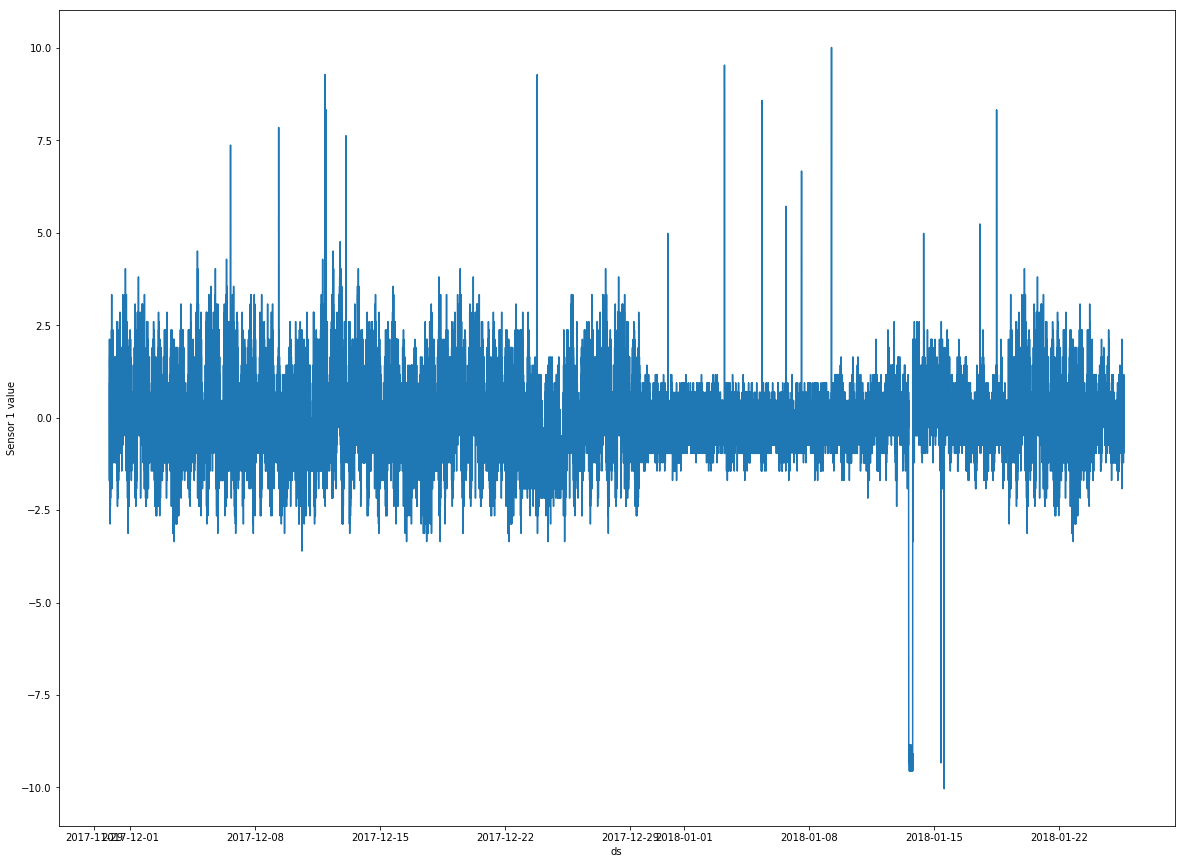

In [25]:
sns.lineplot(data=full_df, x='ds', y='Sensor 1 value')

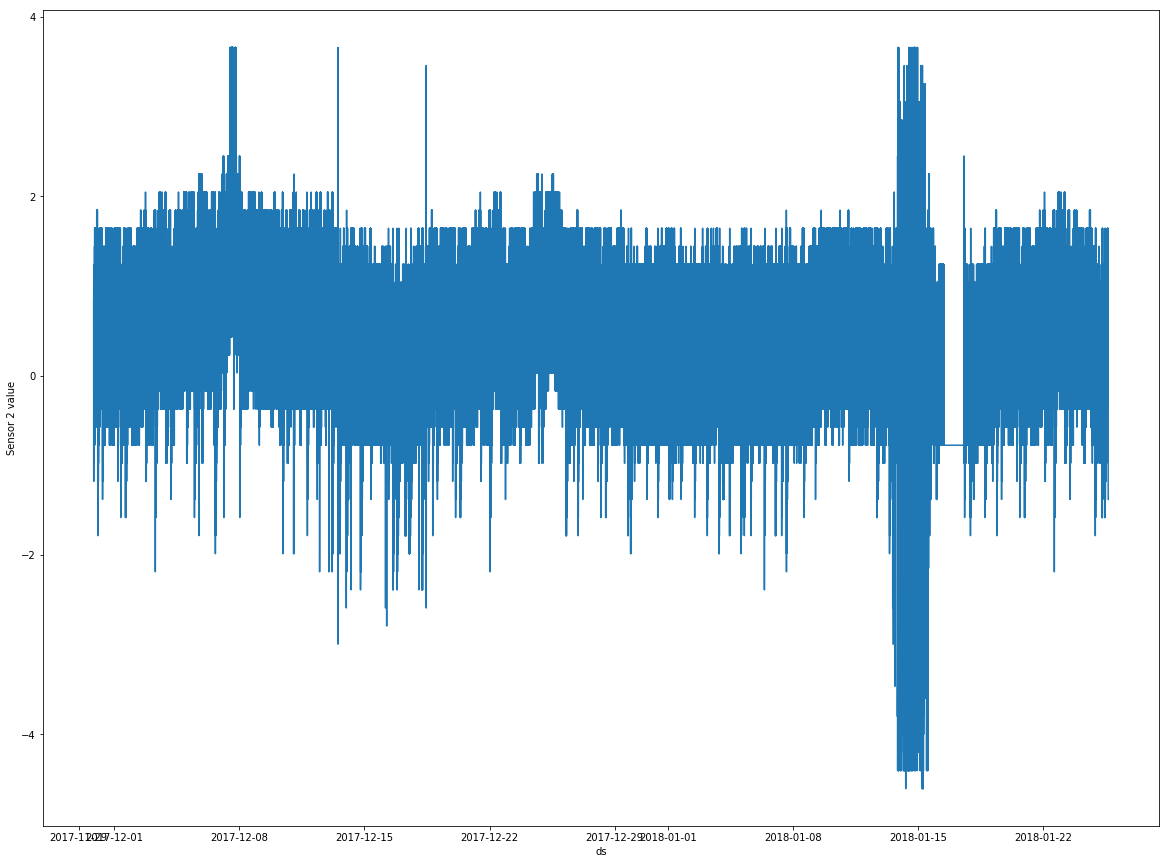

In [26]:
sns.lineplot(data=full_df, x='ds', y='Sensor 2 value')

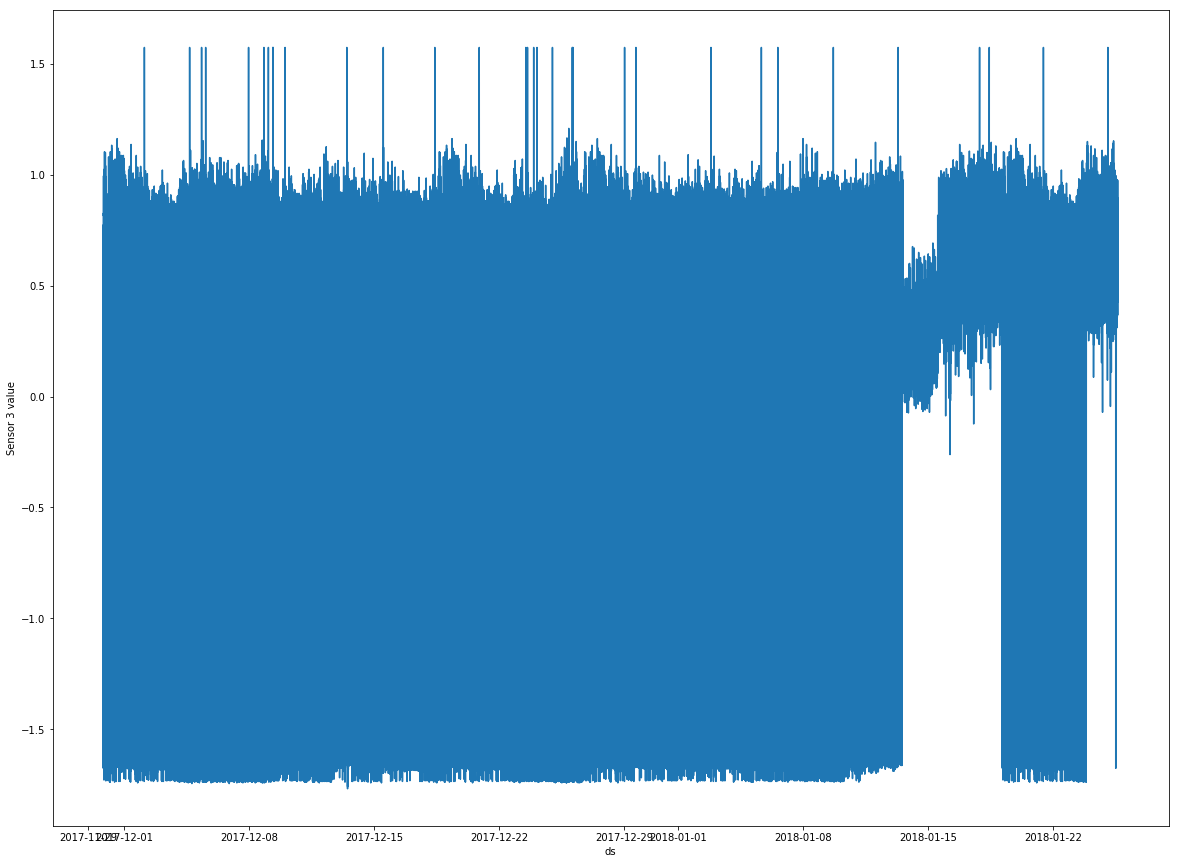

In [27]:
sns.lineplot(data=full_df, x='ds', y='Sensor 3 value')

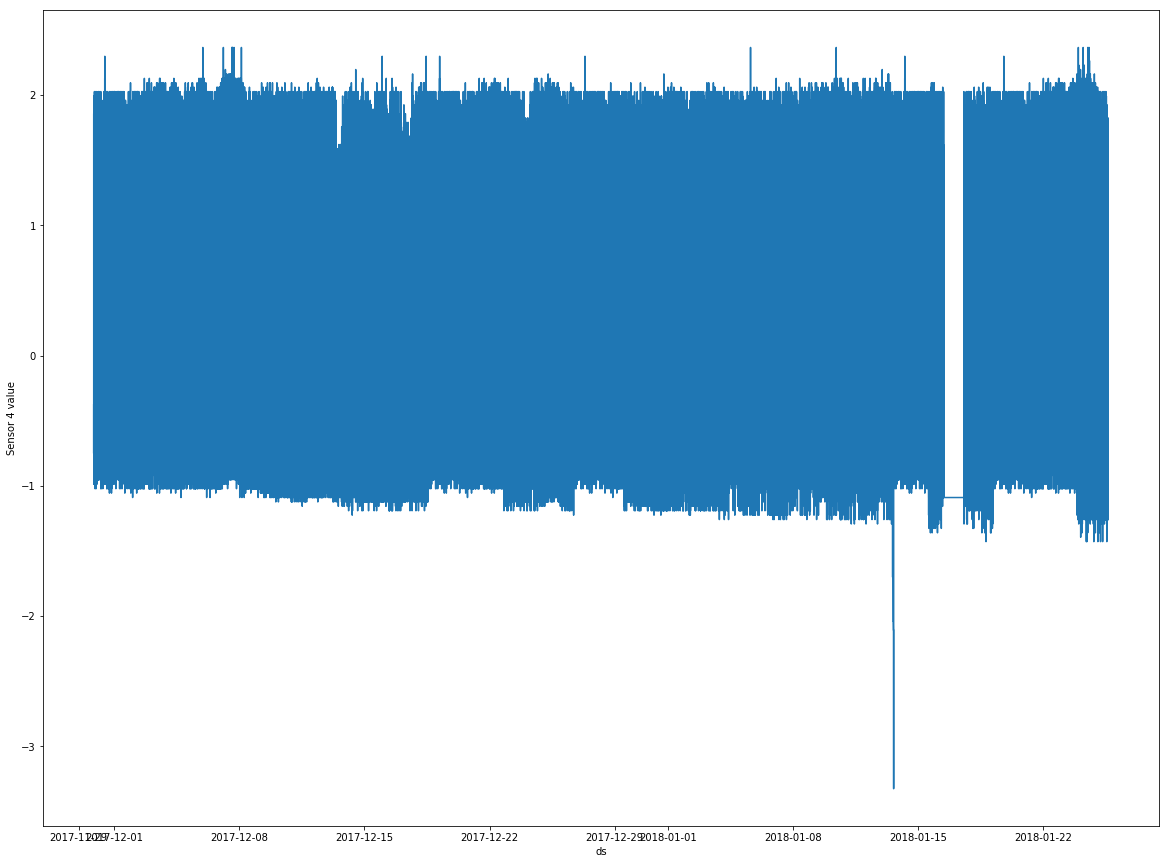

In [28]:
sns.lineplot(data=full_df, x='ds', y='Sensor 4 value')

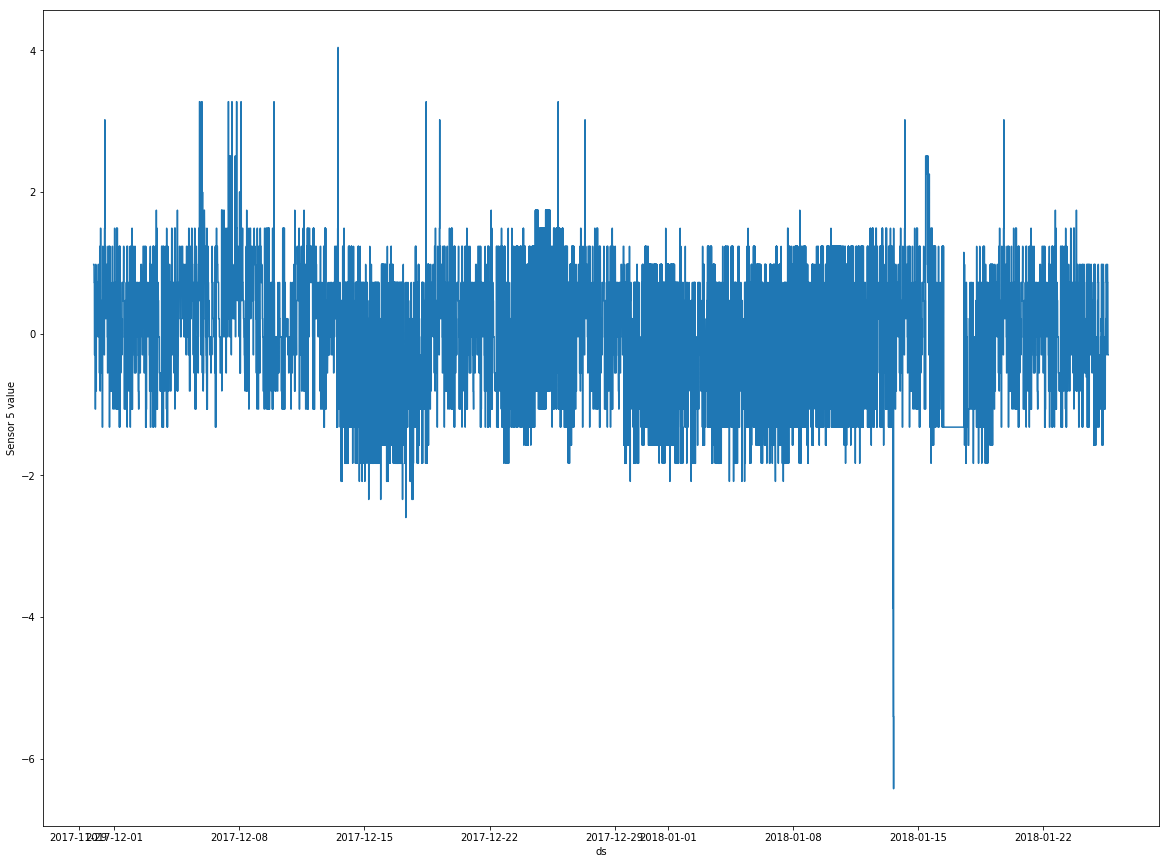

In [29]:
sns.lineplot(data=full_df, x='ds', y='Sensor 5 value')